**Author: Andy Tzanidakis**

Work in Progress

In [48]:
from astropy.io import ascii
import os 
from gatspy import datasets, periodic
import gatspy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20

## Motivation

Do we always need to compute the periodogram on sources, or is there a data-driven approach to halt a full Lomb-Scargle when our current data have reached a $\chi^2$ minimum? Here I develop some general ideas on how we can do this in a data-driven sense.

In [49]:
# Load ELASTICC photometry
phot = ascii.read("../data/rrl_sample.ascii") # or you can choose eb_sample.ascii

In [50]:
phot, phot.meta # file contains metadata for true period

(<Table length=208>
    mjd        flux     flux_err band
  float64    float32    float32  str1
 ---------- ---------- --------- ----
 60278.2911  3681.0315  36.57585    z
 60283.2863 -1764.3602 13.710005    g
 60283.3028 -2300.0173 17.559978    r
  60285.312  2187.8438 28.773987    i
 60287.1184  100.92697 23.158018    u
 60290.2895 -235.33426 22.382057    u
 60290.3059 -2714.4348 20.622112    g
 60291.0925  546.45776  27.38656    u
 60291.1096  2672.9253  23.64777    g
 60295.1306   4244.068 28.945269    g
        ...        ...       ...  ...
 61364.2879 -1745.2043 30.833288    z
 61365.3138 -1796.6178 18.645939    g
 61365.3331 -1679.2498 21.881714    r
 61366.3019   862.8603 31.144424    z
 61366.3169  605.03534 48.903126    Y
 61368.3075 -3052.1965 34.953777    z
 61368.3212 -3147.9678 55.378635    Y
 61378.1801 -3376.2844 24.747478    r
 61378.1969 -2064.6245 25.557697    i
  61379.286 -234.22444 22.143238    u,
 OrderedDict([('true_period', 0.5802)]))

## Demo on the Single-Band Case

In [7]:
r = phot['band']=='r' # start with r-band

Text(0, 0.5, 'Flux')

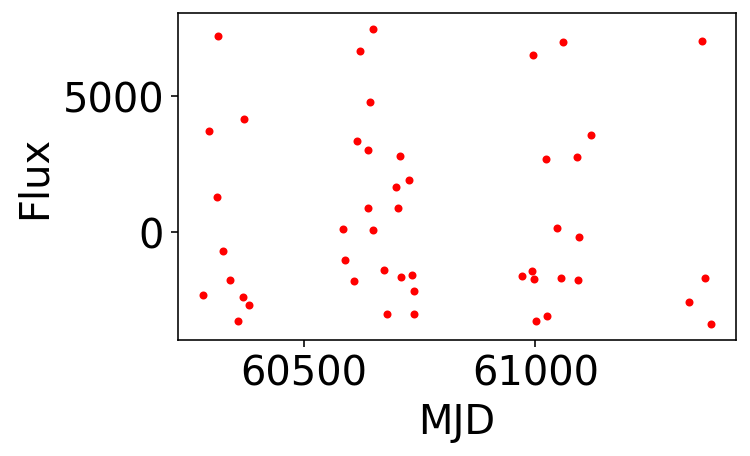

In [13]:
plt.figure(figsize=(5,3))
plt.errorbar(phot['mjd'][r], phot['flux'][r], phot['flux_err'][r], 
            fmt='.', color='red')
plt.xlabel("MJD")
plt.ylabel("Flux")

In [308]:
model = periodic.LombScargle(fit_period=True, optimizer_kwds={"quiet": False},
                                      Nterms=8,
                                      center_data=True)
model.optimizer.period_range = (0.1, 1)                                   
                                      
model = model.fit(phot['mjd'][r], phot['flux'][r], phot['flux_err'][r])  

print (f"LombScargle Best Period {model.best_period.round(4)} days")

bp = model.best_period # best period in days

Finding optimal frequency:
 - Estimated peak width = 0.00574
 - Using 5 steps per peak; omega_step = 0.00115
 - User-specified period range:  0.1 to 1
 - Computing periods at 49271 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
LombScargle Best Period 0.5802 days


Text(0, 0.5, 'Flux')

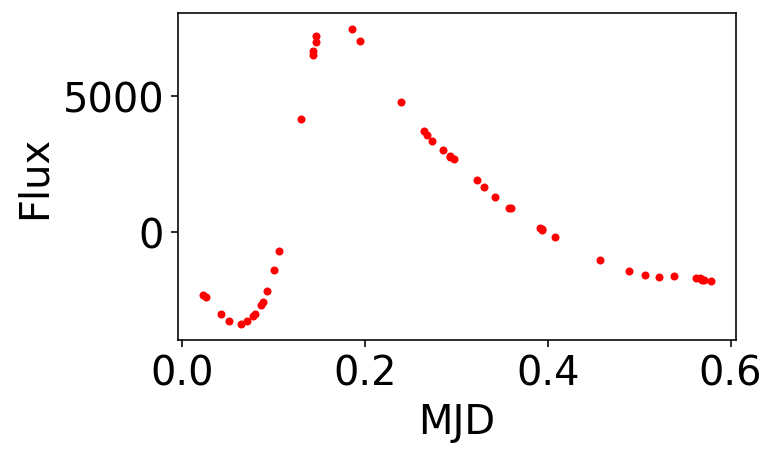

In [309]:
plt.figure(figsize=(5,3))
plt.errorbar(phot['mjd'][r]%bp, phot['flux'][r], phot['flux_err'][r], 
            fmt='.', color='red')
plt.xlabel("MJD")
plt.ylabel("Flux")

<ErrorbarContainer object of 3 artists>

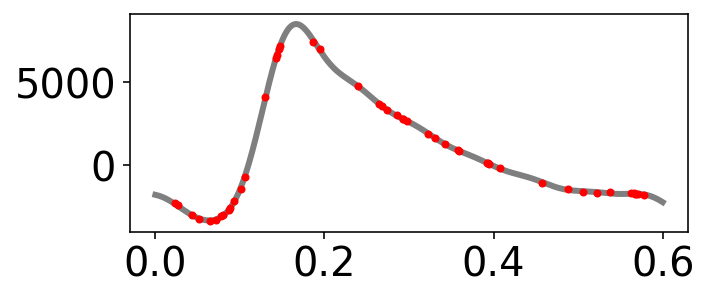

In [311]:
time = np.linspace(0, 0.6, 1000)
lc_model = model.predict(time, period=bp)

plt.figure(figsize=(5,2))
plt.plot(time, lc_model, 
        color='k', lw=3, alpha=0.5)
plt.errorbar(phot['mjd'][r]%bp, phot['flux'][r], phot['flux_err'][r], 
            fmt='.', color='red')


In [312]:
x, y, err = phot['mjd'][r], phot['flux'][r], phot['flux_err'][r]
xs = x%bp

In [313]:
ss = np.argsort(xs)
xx, yy, err0 = xs[ss], y[ss], err[ss]

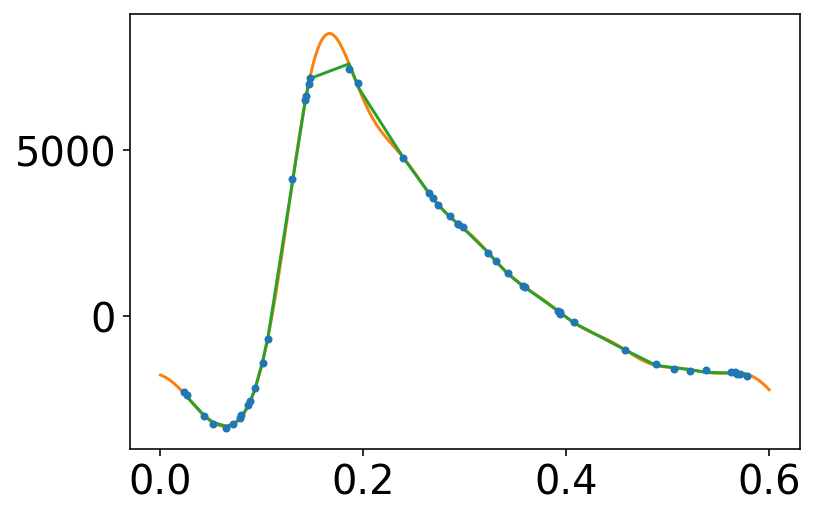

In [347]:
plt.errorbar(xx, yy, err0, fmt='.')
plt.plot(time, lc_model)
plt.plot(xx, model.predict(xx, period=bp))

In [315]:
def chi_dof(y_data, sigma_data, y_model, dof=1):
    z = (y_data - y_model)/sigma_data
    chi2 = np.sum(z**2)
    try:
        N = len(y_data)
    except:
        N = 1
    return chi2/(N-dof)

In [316]:
chi_dof(yy, err0, model.predict(xx, period=bp), dof=8) # chi-square base model

4.283479608668885

In [267]:
x_new, y_new, err_new = 61378+np.random.randint(0, 100), np.min(yy)+10, 10
x_new0 = x_new%bp

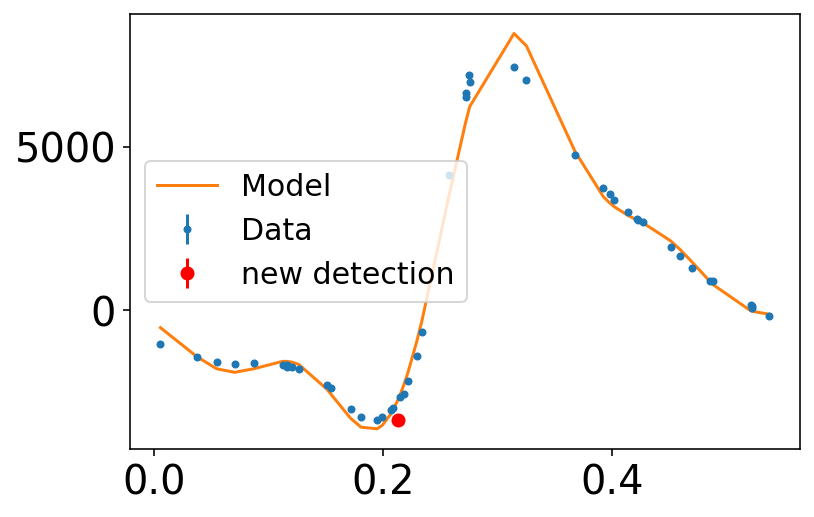

In [268]:
plt.errorbar(xx, yy, err0, fmt='.', 
            label='Data')

plt.plot(xx, model.predict(xx, period=bp), 
        label='Model')
plt.errorbar(x_new0, y_new, err_new, fmt='o', color='red', 
            label='new detection')
plt.legend(fontsize=15)

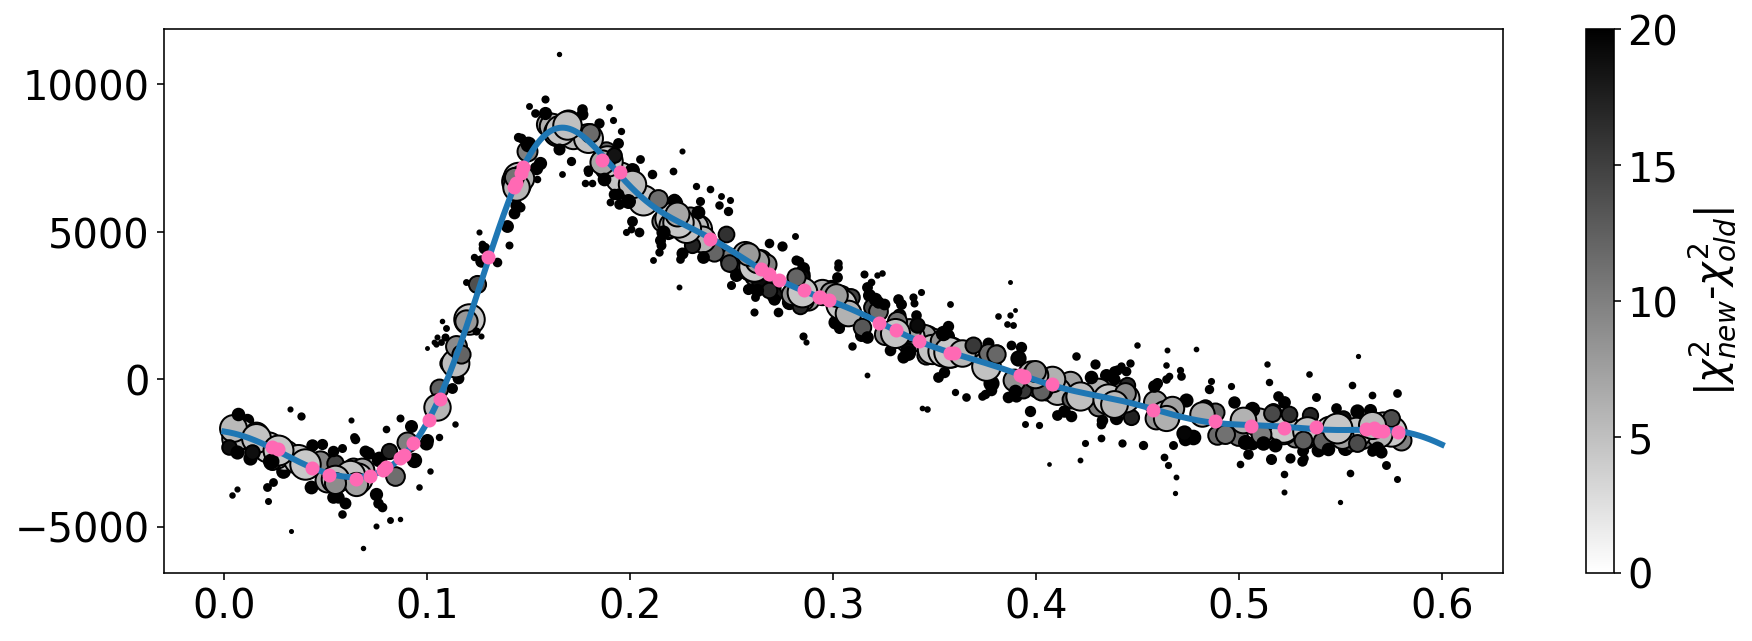

In [401]:
plt.figure(figsize=(15,5))
plt.errorbar(xx, yy, err0, fmt='o', 
            label='Data', 
            color='hotpink')

plt.plot(time, model.predict(time, period=bp), 
        label='Model', lw=3)

for _ in range(500):
    jr = np.random.randint(0, len(xx))
    epo = np.random.randint(0, 1_000)
    x_new, y_new, err_new = xx[jr]+epo, model.predict(xx[jr]+epo, period=bp)+np.random.normal(0, 1e3), abs(np.random.normal(50, 5))
    x_new0 = x_new%bp
    XHI = chi_dof(y_new, err_new, model.predict(x_new0, period=bp), dof=8)

    plt.scatter(x_new0, y_new, c=abs(XHI-4.3), vmin=0, vmax=20, 
               cmap='binary', s=(1/abs(XHI-4.3))*1e3, edgecolor='k')
plt.colorbar(label='|$\chi^2_{new}$-$\chi^{2}_{old}$|')
